In [1]:
import pandas as pd
import math
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dfData = pd.read_csv('/home/archit/Desktop/ad vs organic/final_combined_organic_duration2.csv').drop('Unnamed: 0', axis =1)
dfData.columns

Index(['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'],
      dtype='object')

In [3]:
pd.value_counts(dfData['licensedContent'])

True     118272
False      2604
Name: licensedContent, dtype: int64

In [4]:
pd.value_counts(dfData['definition'])

hd    75167
sd    45709
Name: definition, dtype: int64

In [5]:
pd.value_counts(dfData['Channel country'])

IN    60945
EG    48994
TH     3085
VN     2787
KR     1551
IT     1207
NL      597
US      439
ID      417
CA      351
AU      203
GB      178
ES       66
MX       56
Name: Channel country, dtype: int64

### Categories exploration
graph of categories exploration and views

,vid,Mean Views
categoryId,,
23.0,846,596243
1.0,3119,181611
24.0,73517,146219
22.0,1764,145961
44.0,19,126540
28.0,360,100051
10.0,9516,88295
19.0,91,88077
27.0,975,44838


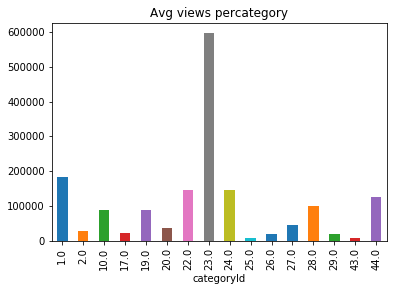

In [6]:
dfData.groupby('categoryId').viewCount.mean().plot(kind = 'bar', title = 'Avg views percategory')
avVal = dfData.groupby('categoryId').viewCount.mean().fillna(0).astype(dtype = 'int64').sort_values(ascending = False)
dfCat = dfData.groupby('categoryId').count()
dfCat['Mean Views'] = avVal
dfCat = dfCat[['vid', 'Mean Views']]
dfCat.sort_values(by = ['Mean Views'], ascending = False)

Next we will set up our input dataset and define the function for model training

In [7]:
def input_dataset(dfData, views =0, categories =[], country= ['IN']):
    """manipulates input dataframe according to input parameters.
    Args:
        dfData: input dataset
        views: minimum number of views in dfData.Default = 0.
        categories: list of categories to be present in final dataset.Default is empty list(all categories)
        country: List of countries whose videos should be present in dataSet. Default is India.
    Returns:
        dataset to train model on
    """
    # slice dataset with viewCount larger than views
    dfData = dfData[dfData['viewCount'] >= views]
    # concat dfData according to categories
    categoryIds =(dfData['categoryId'].dropna().unique()).tolist()
    # create temporary df
    tempDf = pd.DataFrame(columns = ['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'])
    for categoryId in categoryIds:
        df = dfData[dfData['categoryId'] == categoryId]
        keys = []
        keys[0], keys[1] = tempDf['categoryId'][0], df['categoryId'][0]
        tempf = pd.concat([tempDf, df], ignore_index = True, keys = keys)
        
    # select dataframe according to categories
    if len(categories) != 0:
        dfData = tempDf.loc[categories]
    else:
        dfData = tempDf
    
    # choosing countries
    if len(country) != 0:
            dfData = dfData.loc[dfData['Channel country'] == country, ]
    else:
        dfData = dfData.loc[dfData['Channel country'] == 'IN']
        
    return dfData

In [8]:
def preprocessing(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1).rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1).rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left').merge(dfAdStats2, on = 'vid', how = 'left')
    return dfMergedData

In [9]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData['Definition'] = dfData['definition'].apply(lambda x: 1 if x=='hd' else 0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [10]:
def train_model(model):
    """Trains the dataSet using Gradient Boosted Regressor
    Args:
    input_features: input feature set
    model: an int. 1 to predict organic views, 2 to predict advertisement views
    Returns:
    A Pandas "Dataframe' containing targets and corresponding prediction after training the model.
    """
    

Now we will use standard metrics and evaluate our result

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [ ]:
r2_score(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
np.sqrt(mean_squared_error(dfVal['ad%'],dfVal['Predicted Ad %']))

In [ ]:
mean_absolute_error(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
bins =int( (dfVal['Diff'].max() - dfVal['Diff'].min())/5)
gh = plt.hist(dfVal['Diff'], bins = bins)
freq, error = gh[0], gh[1]
plt.ylabel('Number of videos')
plt.xlabel('error')
plt.title('Frequiency table of diff in ad%')
plt.show()

In [ ]:
freq = freq.astype('int64')
dfErr = pd.DataFrame()
dfErr['Error'] = pd.Series(error)
dfErr['Frequency'] = pd.Series(freq)
dfErr['Frequency Percentage'] = dfErr['Frequency']/ dfErr['Frequency'].sum() * 100
dfErr

Now we will look for videos with error in prediction > 30 and figure out why.

In [ ]:
dfErr[np.abs(dfErr['Error'])>30]

In [29]:
# Loading ad stats dataset
dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv')
dfAdStats2 = dfAdStats.drop(['ch_id','Unnamed: 0'], axis =1)
dfAdStats2.rename(columns = {'video_id':'vid'}, inplace = True)
dfAdStats2.shape

(246184, 2)

In [41]:
# Loading perv stats dataset
dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv')
dfPrevStats = dfPrevStats.drop(['Unnamed: 0'], axis =1)
dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

dfPrevStats.head()

,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,vid
0,9.0,5.0,112.0,2016-08-25T03:48:52.000Z,21007.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 13 - Hà...,NaN
1,7.0,6.0,77.0,2016-11-15T06:59:55.000Z,19326.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 14 - Kh...,LPqCSwCNI5w
2,28.0,12.0,109.0,2016-11-15T07:01:46.000Z,33071.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 17 - Gi...,0LGl5jbnrlU
3,8.0,9.0,84.0,2016-11-15T07:01:55.000Z,29516.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 18 - C...,jFFSYwdku9M
4,12.0,18.0,145.0,2016-11-15T07:02:03.000Z,49653.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 19 - Ăn...,HvFNGb-nrRU


### Merging Dataset

In [42]:
dfMergedData = dfData2.merge(dfPrevStats, on = 'vid', how = 'left')
dfMergedData = dfMergedData.merge(dfAdStats2, on = 'vid', how = 'left')

In [43]:
dfMergedData.columns

Index(['Unnamed: 0', 'vid', 'channelId', 'duration', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount',
       'PrevTitle', 'ad%'],
      dtype='object')

In [44]:
dfMergedData.to_csv("/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv")

In [45]:
dfMergedData = pd.read_csv('/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv')

### Picking up traininig set and validation set

In [46]:
dfTrainingSet = dfMergedData.loc[dfMergedData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [47]:
dfValidationSet = dfMergedData.loc[dfMergedData['ad%']>0, ]

dfValidationSet.shape

(8003, 27)

dfTrainingSet.to_csv("/home/archit/Desktop/ad vs organic/training_data_ad_vs_org3.csv")


In [48]:
dfValidationSet['orgViews'] = dfValidationSet['viewCount']*(100-dfValidationSet['ad%'])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
dfValidationSet.drop('viewCount', axis=1, inplace= True)
dfValidationSet.rename(columns = {'orgViews':'viewCount'}, inplace = True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/archit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
dfTrainingSet = pd.concat([dfTrainingSet, dfValidationSet], ignore_index = True)

In [24]:
dfTrainingSet.shape

(36515, 26)

In [25]:
dfValidationSet.to_csv('/home/archit/Desktop/ad vs organic/validation_data_ad_vs_org3.csv')

### Feature engineering


In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
def feature_engineer2(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount'],axis =1)
    
    dfData = dfData.dropna()
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData = dfData.drop(['title','description','publishedAt','','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [52]:
df = feature_engineer(dfTrainingSet)
#df.to_csv('/home/archit/Desktop/ad vs organic/trainSet2.csv')

In [68]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X = X.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
y.shape

(112873,)

In [69]:
X.columns

Index(['vid', 'duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio'],
      dtype='object')

In [55]:
#X.to_csv('/home/archit/Desktop/ad vs organic/trainSET.csv')

### Modeling

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor

In [71]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("Gbr005.pickle.dat", "wb"))

In [72]:
pred = reg.predict(test_X)

In [73]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
44138,411.0,101.860164,lhpiPhfw8m8,309.139836
31600,881.0,-105.292991,2DEfSW3e3Hg,986.292991
27166,533.0,-201.823546,ZlBuyx8qz64,734.823546
67319,3926.0,1070.292623,fM38i1eHr98,2855.707377
42187,385.0,200.500859,_R4DWeJhz7Y,184.499141


In [74]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:2387.4454790550158


In [75]:
1011.0650776175543/dfEval['Actual'].mean()

0.04029664809978987

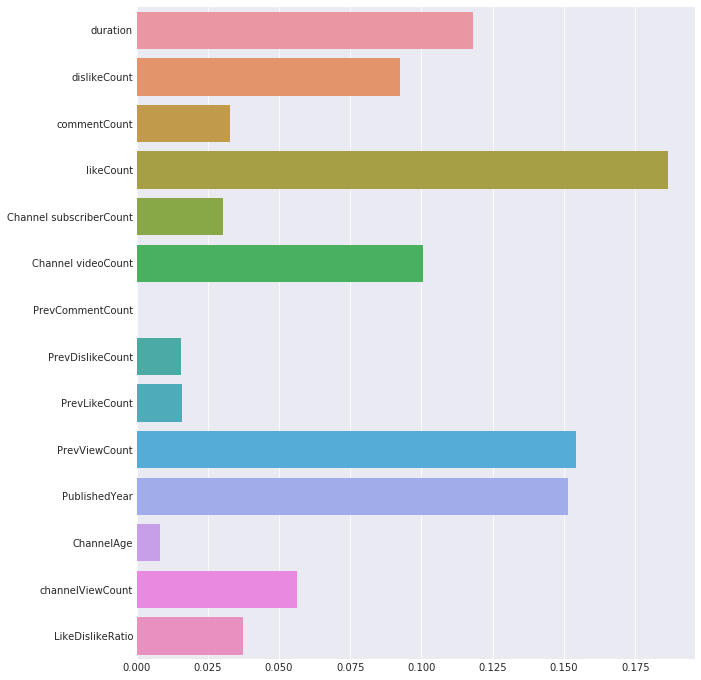

In [76]:
X = X.drop('vid', axis = 1)
sns.set_style('darkgrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

### Modeling on validation set

In [91]:
df = feature_engineer(dfValidationSet)